# Estudo da distribuição dos aminoácidos em torno dos locais de fosforilação

### Requisitos

- numpy
- pandas
- matplotlib
- Python 3.6+

### Dados

Ficheiro _Unitprot text_ com a informação sobre as proteínas da levedura _S. cerevisiae_. Para obter este ficheiro,

- na UniProt procurar pelo "proteoma" da levedura _S. cerevisiae_ [www.uniprot.org/proteomes/UP000002311](https://www.uniprot.org/proteomes/UP000002311)
- Passar para resultados UniProtKB em "Map to Reviewed"
- Download -> Text
- Se o download tiver sido em modo "compressed", extraír o ficheiro do zip.
- Alterar o nome do ficheiro para `uniprot_scerevisiae_reviewed.txt`


## Extração dos dados

In [1]:
data_filename = 'uniprot_scerevisiae_reviewed.txt'

### Leitura de um ficheiro _UniProt text_

In [2]:
def read_Uniprot_text(filename):
    """Reads a UniProt text file and splits into a list of protein records."""
    
    with open(filename) as uniprot_file:
        whole_file = uniprot_file.read()

    records = whole_file.split('//\n')
    
    # remove empty records
    # records = [p for p in records if len(p) != 0]
    # since we know that it is the last one only...
    records.pop(-1)
    return records

prots = read_Uniprot_text(data_filename)

print(f'The number of protein records in "{data_filename}" is {len(prots)}')

The number of protein records in "uniprot_scerevisiae_reviewed.txt" is 6049


### Extração da informação de cada proteína

In [3]:
def extract_info(record):
    """Reads a UniProt text record and returns a dict with extrated information.
    
    The returned dict has the following fields:
    
    'ac': the UniProt Access Id,
    'n': the sequence length, 
    'seq' : the sequence of the protein
    'phospho': a dictionary that associates the location of phosphorylations (int, as keys)
               with the code S, for a phosphoserine or T, for a phosphothreonine.
    
    Other types of phosphorylations are ignored.
    """
    
    IDline, ACline, *otherlines = record.splitlines()
    
    # Extract UniProt AC and number of amino acids
    # Example (first two lines):
    # ID   AB140_YEAST             Reviewed;         628 AA.
    # AC   Q08641; D6W2U2; Q08644;
    
    ac = ACline.split(';',1)[0].split()[1]
    n = int(IDline.split()[3])
    
    # Extract phosphorylation FT lines and sequence lines
    # Process phsophorylation lines
    # Example of phosphorylation lines
    # FT   MOD_RES     150    150       Phosphothreonine.
    # FT   MOD_RES     230    230       Phosphoserine; by PKA; in vitro.
    
    sequence_lines = []
    phosphorylations = {}
    
    for line in otherlines:
        if line.startswith('  '):
            sequence_lines.append(line)
        elif line.startswith('FT   MOD_RES'):
            FTcode, MOD_RES, start, end, Ptype, *rest = line.split()
            if 'Phosphothreonine' in Ptype:
                phosphorylations[int(start)] = 'T'
            elif 'Phosphoserine' in Ptype:
                phosphorylations[int(start)] = 'S'
    
    # join and clean sequence lines
    seq = ''.join(sequence_lines).replace(' ', '')
        
    # Return dictionary of extracted information
    return {'ac': ac, 'n': n, 'seq' : seq, 'phospho': phosphorylations}

# test with protein 0:
extract_info(prots[0])

{'ac': 'Q08641',
 'n': 628,
 'seq': 'MGVADLIKKFESISKEEGDATVDTNSSSKPLKSNDETKELHQQESTAVPQEVDVNEEFENEPETINSSRTAEKPLETNLPKPETNEEDEEEGSMSENKIYSKGENADINVNDFQEYKEMENTGAEVLASSVEESDAIQEGVAEETEGIATPKQKENEKNDESEEESANNASEPAEEYSQSEEDADIEQSNGKETENAENASQQANDGSTSTTTSKNKKKKNKKKNKKKRNGNVNTNANVDDSTKTGENDDTTGDTTSSTTSAIQEVNDLEVVDDSCLGIDQQHNREHLKALTQDVKEETLENIAHEGRGDNTGDQNAVEKSDFEKSDTEGSRIGRDLPFEFGKRNLTEESDVWDHNAWDNVEWGEEQVQQAEEKIKEQFKHPVPEFDKKLYNENPARYWDIFYKNNKENFFKDRKWLQIEFPILYASTRKDAEPVTIFEIGCGAGNTFFPILKDNENENLRIIAADFAPRAVELVKNSEQFNPKYGHATVWDLANPDGNLPDGVEPHSVDIAVMIFVFSALAPNQWDQAMDNLHKILKPGGKIIFRDYGAYDLTQVRFKKNRILEENFYVRGDGTRVYFFSEEKLREIFTKKYFLENKIGTDRRLLVNRKRQLKMYRCWVQAVFDVPQ',
 'phospho': {93: 'S', 150: 'T', 321: 'S', 326: 'S', 347: 'T'}}

### Criação de dicionários para todas as proteínas, aplicando a função `extract_info()`

In [4]:
all_prots = [extract_info(p) for p in prots]
ntot = len(prots)

# see the first 3, as a test
all_prots[:3]

[{'ac': 'Q08641',
  'n': 628,
  'seq': 'MGVADLIKKFESISKEEGDATVDTNSSSKPLKSNDETKELHQQESTAVPQEVDVNEEFENEPETINSSRTAEKPLETNLPKPETNEEDEEEGSMSENKIYSKGENADINVNDFQEYKEMENTGAEVLASSVEESDAIQEGVAEETEGIATPKQKENEKNDESEEESANNASEPAEEYSQSEEDADIEQSNGKETENAENASQQANDGSTSTTTSKNKKKKNKKKNKKKRNGNVNTNANVDDSTKTGENDDTTGDTTSSTTSAIQEVNDLEVVDDSCLGIDQQHNREHLKALTQDVKEETLENIAHEGRGDNTGDQNAVEKSDFEKSDTEGSRIGRDLPFEFGKRNLTEESDVWDHNAWDNVEWGEEQVQQAEEKIKEQFKHPVPEFDKKLYNENPARYWDIFYKNNKENFFKDRKWLQIEFPILYASTRKDAEPVTIFEIGCGAGNTFFPILKDNENENLRIIAADFAPRAVELVKNSEQFNPKYGHATVWDLANPDGNLPDGVEPHSVDIAVMIFVFSALAPNQWDQAMDNLHKILKPGGKIIFRDYGAYDLTQVRFKKNRILEENFYVRGDGTRVYFFSEEKLREIFTKKYFLENKIGTDRRLLVNRKRQLKMYRCWVQAVFDVPQ',
  'phospho': {93: 'S', 150: 'T', 321: 'S', 326: 'S', 347: 'T'}},
 {'ac': 'P28240',
  'n': 557,
  'seq': 'MPIPVGNTKNDFAALQAKLDADAAEIEKWWSDSRWSKTKRNYSARDIAVRRGTFPPIEYPSSVMARKLFKVLEKHHNEGTVSKTFGALDPVQISQMAKYLDTIYISGWQCSSTASTSNEPGPDLADYPMDTVPNKVEHLFKAQLFHDRKQLEARSKAKSQEELDEMGAPIDYLTPIVADADAGHGGLTAVFKLTKMFIERGAAGIHMEDQTSTNKKCGHMAGRC

### Contagens globais de amino ácidos

In [5]:
aacodes = "ACDEFGHIKLMNPQRSTVWY"

# a dict to hold amino-acid counts, initialized to zero counts
tot_counts = {a:0 for a in aacodes}

# go through each sequence, counting the 20 amino-acids
for prot in all_prots:
    seq = prot['seq']
    for a in aacodes:
        tot_counts[a] = tot_counts[a] + seq.count(a)

# check the result
tot_counts

{'A': 161165,
 'C': 37272,
 'D': 171368,
 'E': 191475,
 'F': 130230,
 'G': 145859,
 'H': 63790,
 'I': 192640,
 'K': 215472,
 'L': 279286,
 'M': 61252,
 'N': 180800,
 'P': 128556,
 'Q': 115998,
 'R': 130510,
 'S': 263906,
 'T': 173669,
 'V': 163152,
 'W': 30543,
 'Y': 99420}

Ou, em alternativa, aplicar a função `sum()` a listas de contagens

In [6]:
aacodes = "ACDEFGHIKLMNPQRSTVWY"

# a dict to hold amino-acid counts
tot_counts = {}

for a in aacodes:
    tot_counts[a] = sum([prot['seq'].count(a) for prot in all_prots])
    
# check the result
tot_counts

{'A': 161165,
 'C': 37272,
 'D': 171368,
 'E': 191475,
 'F': 130230,
 'G': 145859,
 'H': 63790,
 'I': 192640,
 'K': 215472,
 'L': 279286,
 'M': 61252,
 'N': 180800,
 'P': 128556,
 'Q': 115998,
 'R': 130510,
 'S': 263906,
 'T': 173669,
 'V': 163152,
 'W': 30543,
 'Y': 99420}

### Restringir às proteínas que têm informação sobre fosforilações

In [7]:
all_prots = [p for p in all_prots if len(p['phospho']) > 0]

print('The number of proteins with phosphorylation information is', len(all_prots))
print(f'That is {100.0*len(all_prots)/ntot:5.2f} % of the total number of proteins.')

The number of proteins with phosphorylation information is 2022
That is 33.43 % of the total number of proteins.


### Contagem dos aminoácidos em diferentes posições

As posições a considerar são num intervalo entre 5 amino-ácidos antes da posição de fosforilação e 5 amino-ácidos depois da posição de fosforilação.

Estas posições serão representadas pelo intervalo de números inteiros [-5,5], ou seja `range(-5,6)`.

In [8]:
aacodes = "ACDEFGHIKLMNPQRSTVWY"

# dict's to hold amino-acid counts in positions -5..5 around phosphorylation sites
# position 0 is the phosphorylation site

# the computed global counts are also part of the dict's (with key 'global')
S_counts = {'global': tot_counts}
T_counts = {'global': tot_counts}

pos_range = range(-5, 6)

# initialize counts to zero
for p in pos_range:
    S_counts[p] = {a:0 for a in aacodes}
    T_counts[p] = {a:0 for a in aacodes}

for prot in all_prots:
    seq = prot['seq']

    # go through phosphorylation dict for this protein
    for ploc, code in prot['phospho'].items():
        # offset by one because Uniprot numbering of sequences starts at 1
        # and Python list numbering starts at 0
        loc = ploc - 1

        for p in pos_range:
            pos = loc + p
            # if phospho pos is not "out of sequence"...
            if 0 <= pos < prot['n']:
                aminoacid = seq[pos]
                if code == 'T':
                    T_counts[p][aminoacid] = T_counts[p][aminoacid] + 1
                elif code == 'S':
                    S_counts[p][aminoacid] = S_counts[p][aminoacid] + 1

# check one of them   
S_counts[-5]

{'A': 288,
 'C': 9,
 'D': 401,
 'E': 374,
 'F': 125,
 'G': 252,
 'H': 116,
 'I': 240,
 'K': 367,
 'L': 456,
 'M': 81,
 'N': 413,
 'P': 240,
 'Q': 190,
 'R': 276,
 'S': 604,
 'T': 286,
 'V': 274,
 'W': 16,
 'Y': 110}

In [9]:
import pandas as pd
import numpy as np

### Transformação das contagens em _Data frame_'s do módulo _pandas_

In [10]:
Scounts = pd.DataFrame(S_counts)
Tcounts = pd.DataFrame(T_counts)
Scounts

,global,-5,-4,-3,-2,-1,0,1,2,3,4,5
A,161165,288,347,258,356,379,0,245,298,304,279,329
C,37272,9,17,8,24,26,0,10,19,18,16,17
D,171368,401,387,520,327,552,0,638,602,604,440,417
E,191475,374,434,410,410,449,0,395,569,778,477,441
F,130230,125,131,96,111,126,0,233,106,140,182,154
G,145859,252,236,221,229,357,0,193,256,261,208,245
H,63790,116,105,97,97,132,0,55,89,77,77,94
I,192640,240,210,174,235,239,0,368,302,154,290,255
K,215472,367,410,408,269,289,0,95,231,312,263,326
L,279286,456,329,264,331,454,0,440,339,284,512,311


#### Cálculo das frequências

In [11]:
Sfreq = Scounts / Scounts.sum(axis=0)
Tfreq = Tcounts / Tcounts.sum(axis=0)

#check sum of frequencies
#print(Sfreq.sum(axis=0))

# some frequencies will be zero.
# replace them by nan so that we can compute logarithms without a warning
Tfreq = Tfreq.replace(0, np.nan)

Sfreq

,global,-5,-4,-3,-2,-1,0,1,2,3,4,5
A,0.054886,0.056272,0.067721,0.050273,0.069274,0.073350,0.0,0.047416,0.057954,0.059236,0.054513,0.064522
C,0.012693,0.001758,0.003318,0.001559,0.004670,0.005032,0.0,0.001935,0.003695,0.003507,0.003126,0.003334
D,0.058361,0.078351,0.075527,0.101325,0.063631,0.106832,0.0,0.123476,0.117075,0.117693,0.085971,0.081781
E,0.065208,0.073075,0.084699,0.079891,0.079782,0.086898,0.0,0.076447,0.110657,0.151598,0.093200,0.086488
F,0.044351,0.024424,0.025566,0.018706,0.021600,0.024386,0.0,0.045094,0.020615,0.027280,0.035561,0.030202
G,0.049673,0.049238,0.046058,0.043063,0.044561,0.069092,0.0,0.037352,0.049786,0.050857,0.040641,0.048049
H,0.021724,0.022665,0.020492,0.018901,0.018875,0.025547,0.0,0.010644,0.017308,0.015004,0.015045,0.018435
I,0.065605,0.046893,0.040984,0.033905,0.045729,0.046255,0.0,0.071221,0.058732,0.030008,0.056663,0.050010
K,0.073381,0.071708,0.080016,0.079501,0.052345,0.055932,0.0,0.018386,0.044924,0.060795,0.051387,0.063934
L,0.095113,0.089097,0.064208,0.051442,0.064409,0.087865,0.0,0.085156,0.065928,0.055339,0.100039,0.060992


#### Cálculo de $log_2(\frac{f_p}{f_{global}})$

In [12]:
pos_range = range(-5, 6)

Slog2ratios = pd.DataFrame()
Tlog2ratios = pd.DataFrame()

for p in pos_range:
    # skip p==0
    if p != 0:
        Slog2ratios[p] = np.log2(Sfreq[p] / Sfreq['global'])
        Tlog2ratios[p] = np.log2(Tfreq[p] / Tfreq['global'])

Slog2ratios

,-5,-4,-3,-2,-1,1,2,3,4,5
A,0.035981,0.303157,-0.126658,0.335881,0.418363,-0.211053,0.078475,0.110042,-0.009823,0.233365
C,-2.851645,-1.935798,-3.025511,-1.442515,-1.334877,-2.713389,-1.780392,-1.855586,-2.021570,-1.928741
D,0.424955,0.371996,0.795923,0.124736,0.872274,1.081162,1.004366,1.011960,0.558856,0.486766
E,0.164332,0.377299,0.292977,0.291011,0.414263,0.229400,0.762973,1.217123,0.515283,0.407439
F,-0.860684,-0.794735,-1.245446,-1.037959,-0.862935,0.023972,-1.105297,-0.701126,-0.318673,-0.554315
G,-0.012700,-0.109028,-0.206019,-0.156684,0.476053,-0.411270,0.003270,0.033985,-0.289541,-0.047977
H,0.061173,-0.084253,-0.200836,-0.202803,0.233839,-1.029195,-0.327824,-0.533963,-0.530022,-0.236854
I,-0.484423,-0.678758,-0.952311,-0.520704,-0.504193,0.118502,-0.159658,-1.128468,-0.211404,-0.391594
K,-0.033270,0.124883,0.115578,-0.487352,-0.391727,-1.996798,-0.707907,-0.271445,-0.513987,-0.198812
L,-0.094259,-0.566896,-0.886696,-0.562369,-0.114348,-0.159536,-0.528757,-0.781343,0.072851,-0.641013


## Representações gráficas

In [13]:
%matplotlib inline
from matplotlib import pyplot as pl

### Gráfico de barras para _Slog2ratios_, todas as posições num único gráfico

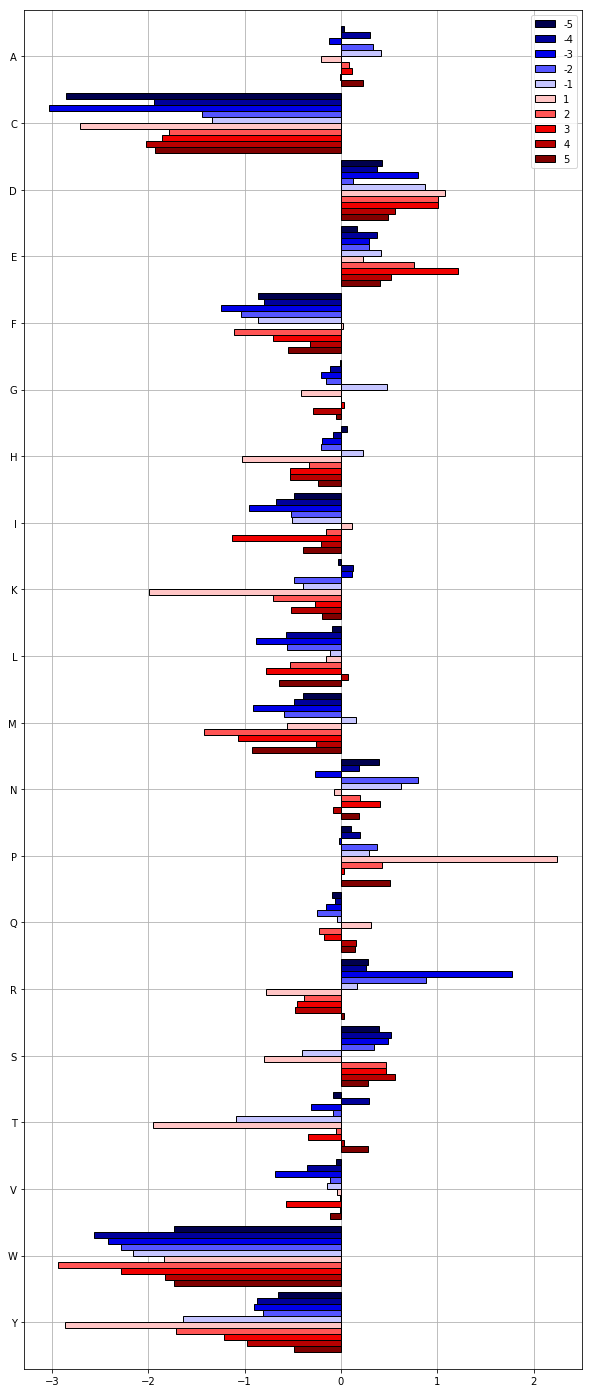

In [14]:
ax = Slog2ratios.plot(kind='barh', figsize=(10,25), subplots=False, sharex=False, ylim=(-3,3), grid=True, layout=(5,2),
                      legend=True, width=0.9, edgecolor='black', colormap='seismic')
ax.invert_yaxis()
ax.set_axisbelow(True)

### Gráfico de barras para _Tlog2ratios_, um gráfico por posição

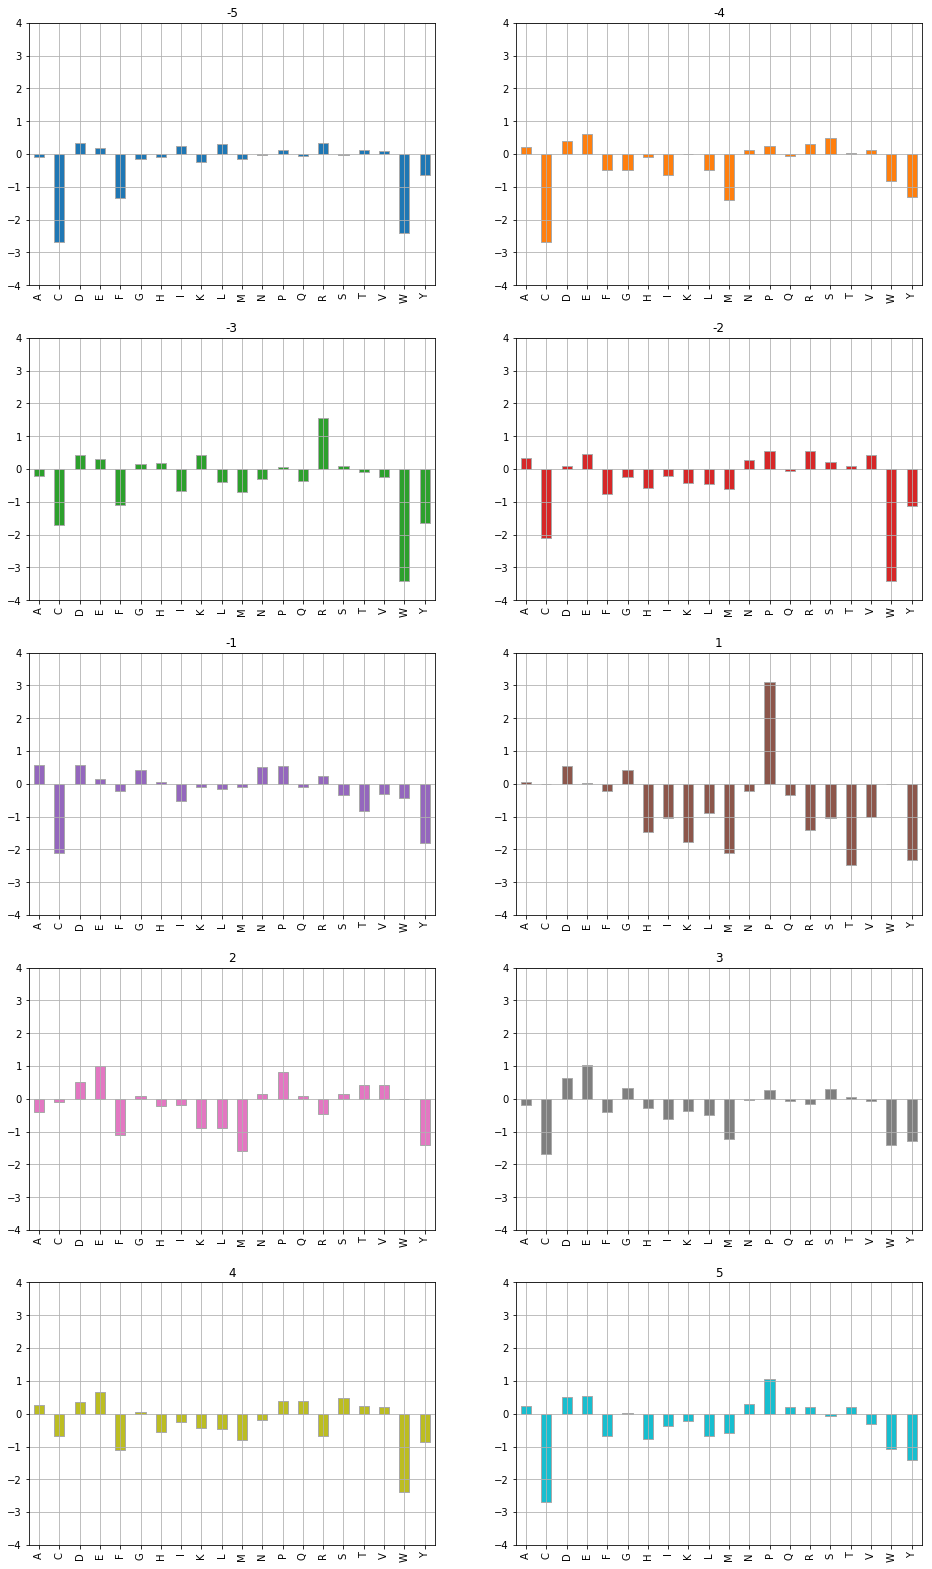

In [15]:
ax = Tlog2ratios.plot(kind='bar', figsize=(16,28), subplots=True, sharex=False, ylim=(-4,4), grid=True, layout=(5,2), 
                      legend=False, edgecolor='darkgrey')